<a href="https://colab.research.google.com/github/ayeonghong928-sudo/AYOUNGHONG/blob/main/WEEK14_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

plt.style.use("default")

# Unzip the dataset file
zip_file_path = "/content/W14_online_retail.csv.zip"
extracted_dir = "/content/"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

df = pd.read_csv(f"{extracted_dir}online_retail.csv", encoding="ISO-8859-1")

# index 컬럼 제거 (과제 요구사항에 따라 preprocessing)
if "index" in df.columns:
    df = df.drop(columns=["index"])

# CustomerID 결측치 제거
df = df.dropna(subset=["CustomerID"])

# 타입 변환
df["CustomerID"] = df["CustomerID"].astype(int).astype(str)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# 이상치 제거 (음수 주문, 0원 단가 제거)
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

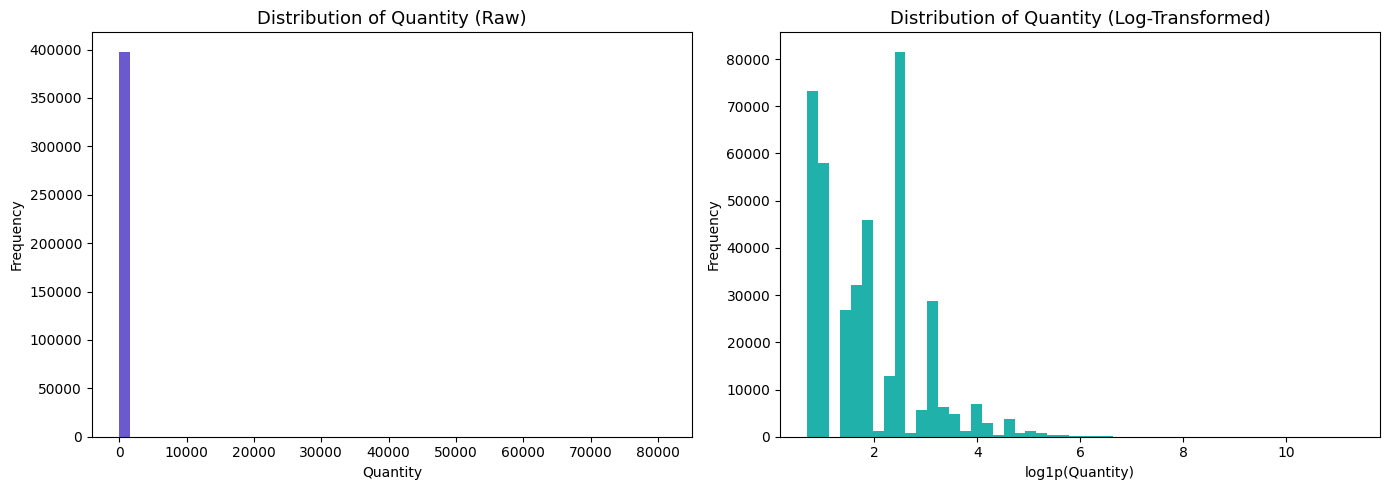

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램 (수량 원본)
ax[0].hist(df["Quantity"], bins=50, color="#6A5ACD")
ax[0].set_title("Distribution of Quantity (Raw)", fontsize=13)
ax[0].set_xlabel("Quantity")
ax[0].set_ylabel("Frequency")

# 로그 변환 히스토그램
ax[1].hist(np.log1p(df["Quantity"]), bins=50, color="#20B2AA")
ax[1].set_title("Distribution of Quantity (Log-Transformed)", fontsize=13)
ax[1].set_xlabel("log1p(Quantity)")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

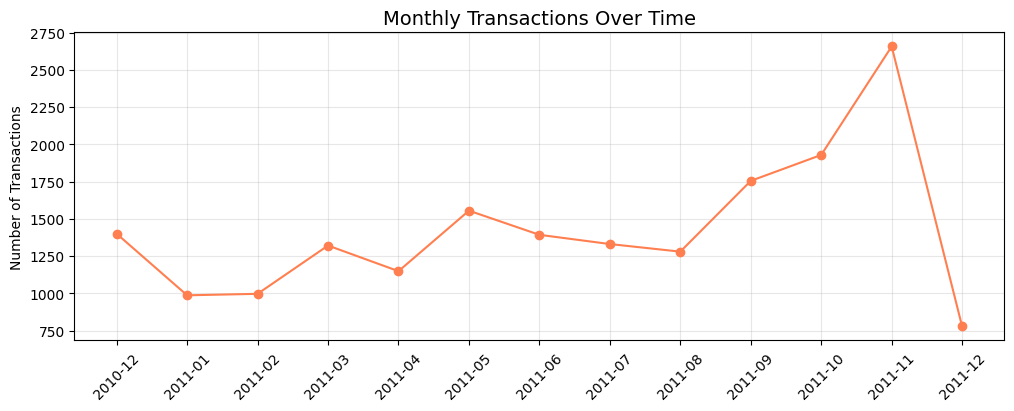

In [4]:
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").astype(str)

monthly_counts = df.groupby("InvoiceMonth")["InvoiceNo"].nunique()

plt.figure(figsize=(12, 4))
plt.plot(monthly_counts.index, monthly_counts.values, marker="o", color="#FF7F50")
plt.title("Monthly Transactions Over Time", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Number of Transactions")
plt.grid(alpha=0.3)
plt.show()

/tmp/ipython-input-3650190992.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.values, y=country_counts.index, palette="crest")


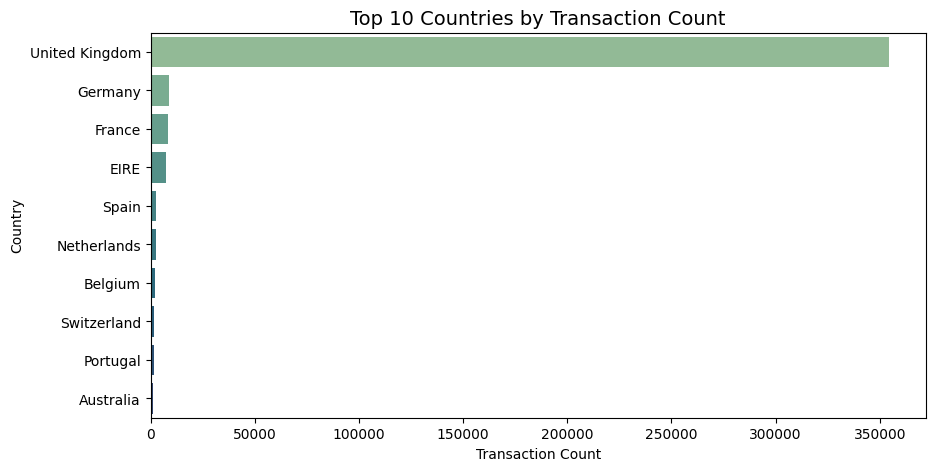

In [5]:
country_counts = df["Country"].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=country_counts.values, y=country_counts.index, palette="crest")
plt.title("Top 10 Countries by Transaction Count", fontsize=14)
plt.xlabel("Transaction Count")
plt.ylabel("Country")
plt.show()

In [7]:
# InvoiceMonth 생성
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").astype(str)

# CohortMonth: 고객 첫 구매 월
df["CohortMonth"] = df.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M").astype(str)

# Cohort Index 계산 함수
def get_month_diff(start, end):
    start_y, start_m = map(int, start.split("-"))
    end_y, end_m = map(int, end.split("-"))
    return (end_y - start_y) * 12 + (end_m - start_m)

df["CohortIndex"] = df.apply(lambda x: get_month_diff(x["CohortMonth"], x["InvoiceMonth"]), axis=1)

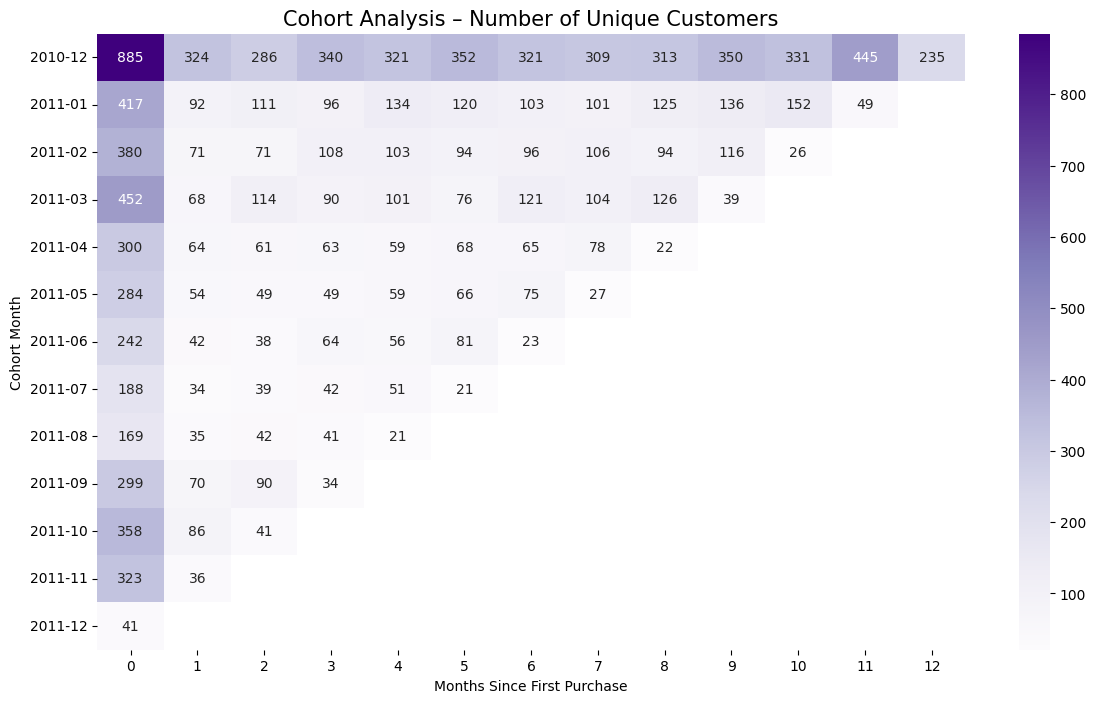

In [8]:
cohort_counts = (
    df.groupby(["CohortMonth", "CohortIndex"])["CustomerID"]
    .nunique()
    .reset_index()
    .pivot(index="CohortMonth", columns="CohortIndex", values="CustomerID")
)

plt.figure(figsize=(14, 8))
sns.heatmap(cohort_counts, annot=True, fmt=".0f", cmap="Purples")
plt.title("Cohort Analysis – Number of Unique Customers", fontsize=15)
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()

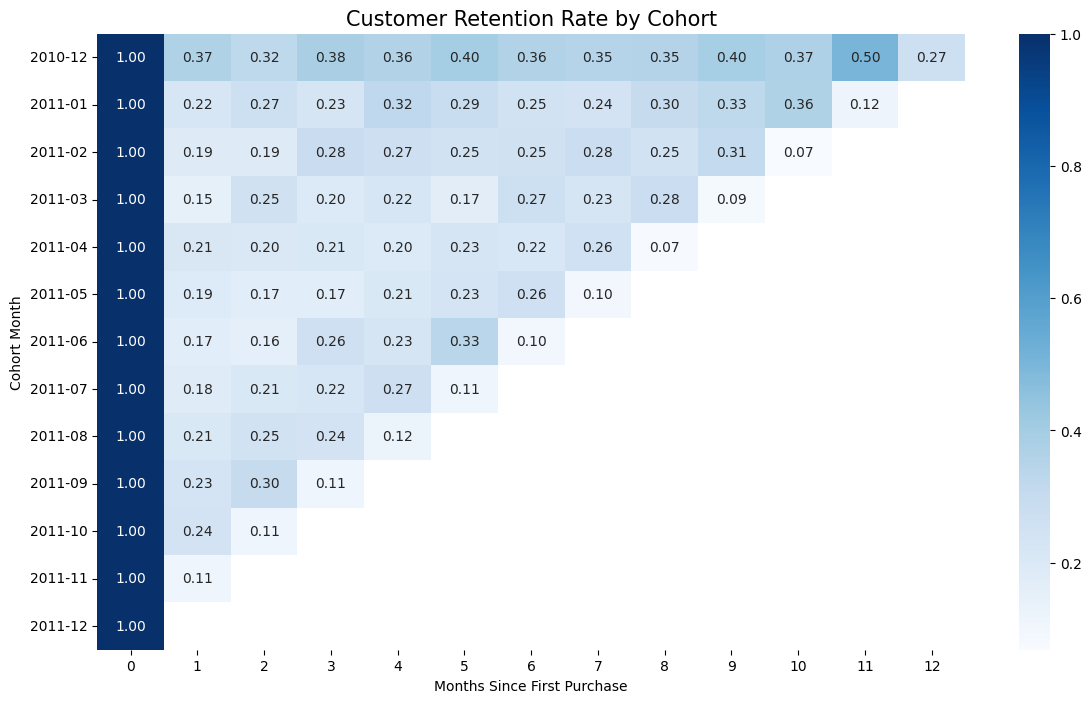

In [9]:
cohort_sizes = cohort_counts.iloc[:, 0]

retention = cohort_counts.divide(cohort_sizes, axis=0)

plt.figure(figsize=(14, 8))
sns.heatmap(retention, annot=True, fmt=".2f", cmap="Blues")
plt.title("Customer Retention Rate by Cohort", fontsize=15)
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()

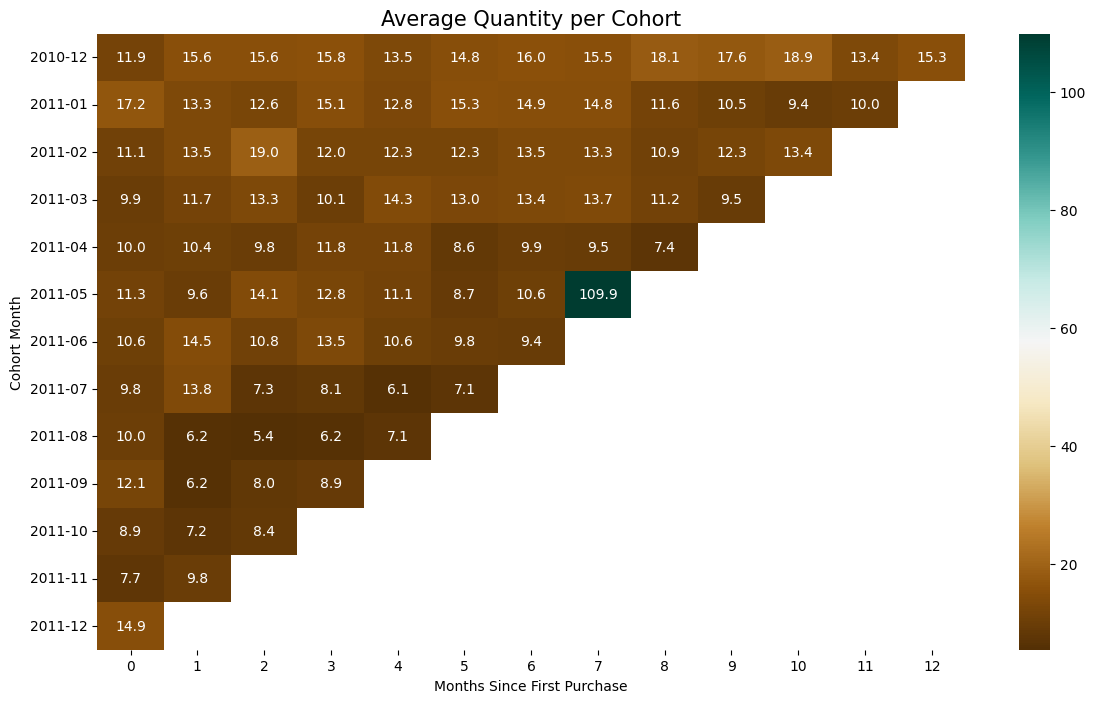

In [10]:
cohort_quantity = (
    df.groupby(["CohortMonth", "CohortIndex"])["Quantity"]
    .mean()
    .reset_index()
    .pivot(index="CohortMonth", columns="CohortIndex", values="Quantity")
)

plt.figure(figsize=(14, 8))
sns.heatmap(cohort_quantity, annot=True, fmt=".1f", cmap="BrBG")
plt.title("Average Quantity per Cohort", fontsize=15)
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()

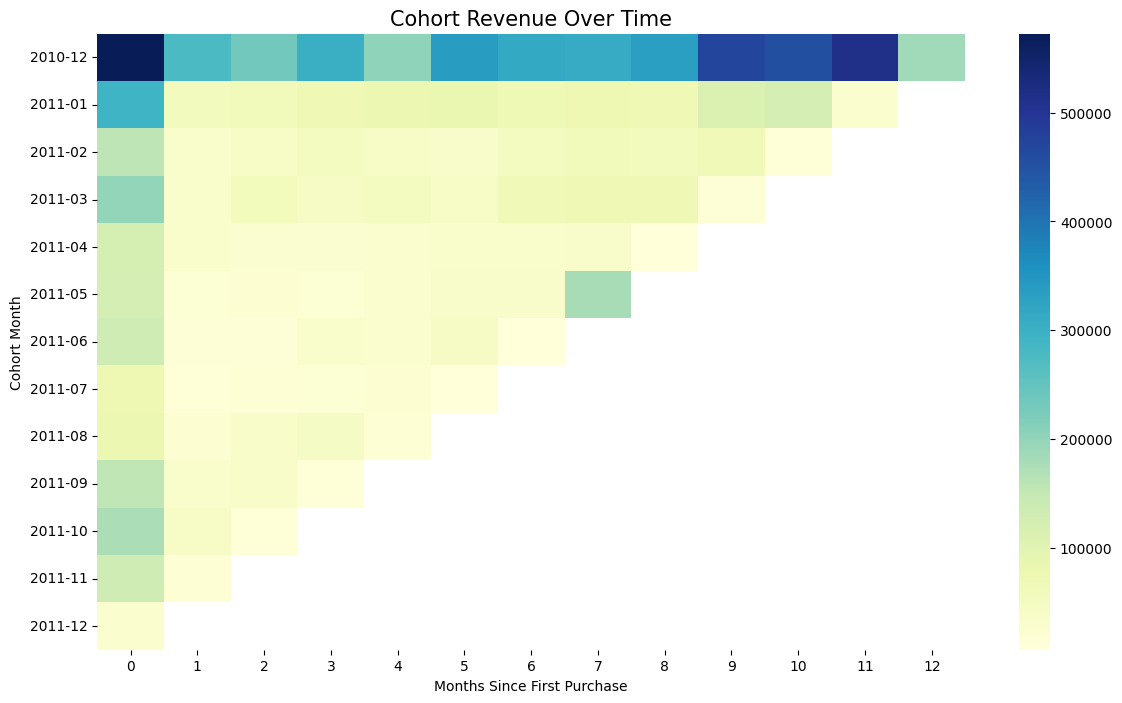

In [11]:
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

cohort_revenue = (
    df.groupby(["CohortMonth", "CohortIndex"])["Revenue"]
    .sum()
    .reset_index()
    .pivot(index="CohortMonth", columns="CohortIndex", values="Revenue")
)

plt.figure(figsize=(14, 8))
sns.heatmap(cohort_revenue, annot=False, cmap="YlGnBu")
plt.title("Cohort Revenue Over Time", fontsize=15)
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()

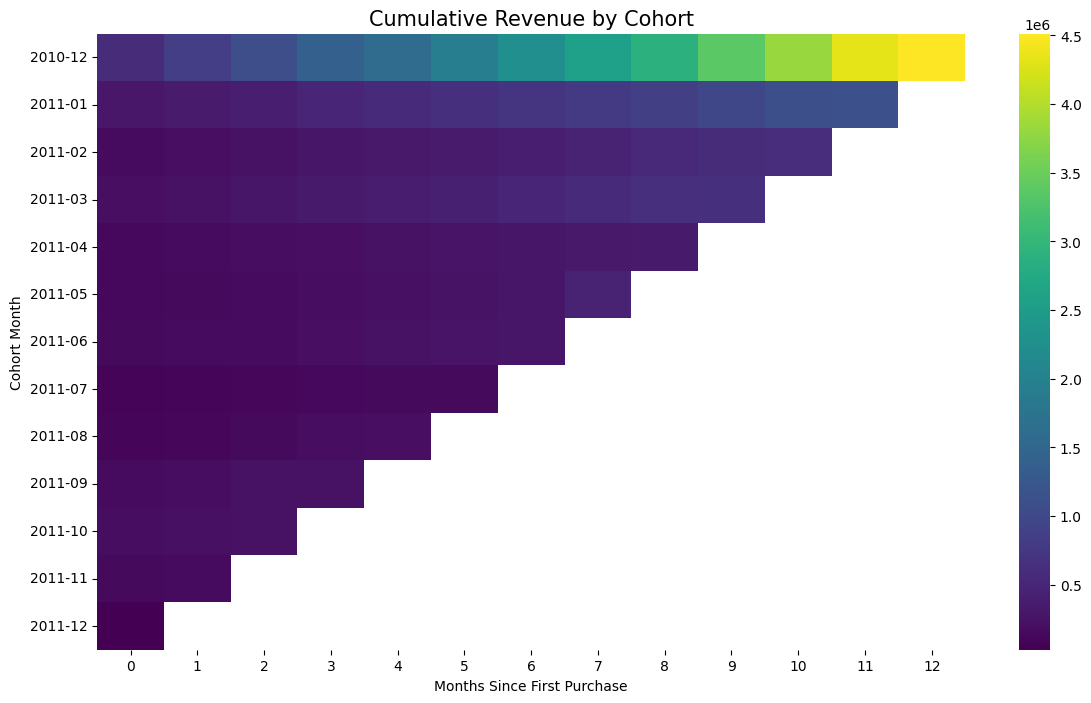

In [12]:
cohort_cum_revenue = cohort_revenue.cumsum(axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(cohort_cum_revenue, annot=False, cmap="viridis")
plt.title("Cumulative Revenue by Cohort", fontsize=15)
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()